In [5]:
import h5py
import numpy as np
import torch, monai
import torchio as tio
from typing import Sequence
from monai.data import ArrayDataset, DataLoader, PersistentDataset
from monai.transforms import Compose, RandAffine, Rand2DElastic, Rand3DElastic
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score
import nibabel as nib
from utils import *

import glob, os
from monai.transforms import (
    Compose,
    LoadImage,
    RandSpatialCrop,
    ScaleIntensity,
    RandFlip,
    RandRotate90
)

from monai.utils import first
from tqdm import tqdm
from utils import *


## 1. Create Dataloader

In [6]:
t1s_dir = 'datasets/IXI/train/t1_misalign_9' # Misaligned data # TODO: Put the proper values on 't1_misalign_#'
t2s_dir = 'datasets/IXI/train/t2'

t1s = sorted(glob.glob(os.path.join(t1s_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(t2s_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
            RandSpatialCrop((96, 96), random_size=False),
            RandFlip(prob=0.5, spatial_axis=0),
            RandFlip(prob=0.5, spatial_axis=1),
            RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ]
    )


# define array dataset, data loader
train_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
train_loader = DataLoader(train_ds, batch_size=30, num_workers=5, shuffle=True, pin_memory=torch.cuda.is_available())
# This is the trainloader


In [7]:
root_dir = 'datasets/IXI/val'

t1s = sorted(glob.glob(os.path.join(root_dir, "t1*.npy")))
t2s = sorted(glob.glob(os.path.join(root_dir, "t2*.npy")))

t1_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )

t2_trans = Compose(
        [
            LoadImage(image_only=True, ensure_channel_first=True),
        ]
    )


# define array dataset, data loader
val_ds = ArrayDataset(t1s, t1_trans, t2s, t2_trans)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=5, pin_memory=torch.cuda.is_available())
# This is the val_loader


## 2. Make original? (PGAN) model

In [ ]:
class Args:
    pass

opt = {'isTrain':True, 'input_nc':1, 'output_nc':1, 'ngf':16, 'ndf':16, 
       'n_layers_D':3, 'norm':'instance','no_dropout':True,'no_lsgan':True, 'init_type':'normal', 
       'gpu_ids':[0], 'checkpoints_dir':'checkpoints', 'name':'Test', 'lambda_vgg':10.0,
       'continue_train':False, 'pool_size':0, 'lr':0.0002, 'beta1':0.5, 'lambda_adv':0.1, 'lambda_A':10.0, 'lmbda_B':10.0, 'lambda_identity':0.0,
       'lr_policy':'lambda', 'epoch_count':1, 'niter':100, 'niter_decay':100, 'which_direction':'AtoB', 'dataroot':'datasets/IXI/train'}
args = Args()
for key, value in opt.items():
    setattr(args, key, value)

from models import create_model
from models.pgan_model import pGAN

model = pGAN()  
model.initialize(args)

## 3. Run training (Epoch by Epoch)

In [ ]:

for epoch in range(1000):
    # Training Stage
    for i, (t1, t2) in enumerate(train_loader): # Train images with patch 96x96
        model.set_input({'A':t1, 'B':t2})
        model.optimize_parameters()
        
    if epoch % 10 == 0:
        # Validation Stage
        psnr, ssim = 0, 0
        for i, (t1, t2) in enumerate(val_loader): # Test it with full FOV
            model.set_input({'A':t1, 'B':t2})
            _psnr, _ssim = model.test()
            psnr += _psnr
            ssim += _ssim
            if i == 0:
                out = model.get_current_visuals()
                plot_images([out['real_A'], out['fake_B'], out['real_B']], ['Real_A', 'Fake_B', 'Real_B']) #TODO: 회색조 이미지를 정상적으로 만들기
        print(f"Epoch {epoch}, Iter {i}, PSNR {psnr/len(val_loader)}, SSIM {ssim/len(val_loader)}")


## 4. Modify the network with monai.GenerativeModels
See `https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_autoencoderkl/2d_autoencoderkl_tutorial.ipynb`

In [8]:
from GenerativeModels.generative.losses import PatchAdversarialLoss, PerceptualLoss
from GenerativeModels.generative.networks.nets import AutoencoderKL, PatchDiscriminator
from monai.config import print_config
from monai.networks.nets import AttentionUnet
from torch.nn import L1Loss
from tqdm import tqdm
from monai.networks.layers import Act
from collections import OrderedDict

import time
from GenerativeModels.generative.losses import PatchAdversarialLoss, PerceptualLoss
from GenerativeModels.generative.networks.nets import AutoencoderKL, PatchDiscriminator
print_config()

MONAI version: 1.1.0
Numpy version: 1.24.3
Pytorch version: 2.0.1+cu118
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: 4.7.1
TorchVision version: 0.15.2+cu118
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-t

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1) #TODO: Put the proper values
print(f"Using {device}")

model = AttentionUnet(spatial_dims=2, in_channels=1, out_channels=1, channels=[32,64,128,256], strides=[1,2,2,2]) # Strides: downsampling layers
model.to(device)

discriminator = PatchDiscriminator(
    spatial_dims=2,
    num_layers_d=3,
    num_channels=64,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation=(Act.LEAKYRELU, {"negative_slope": 0.2}),
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device)

perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="radimagenet_resnet50")
perceptual_loss.to(device)

optimizer_g = torch.optim.Adam(params=model.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=5e-4)

l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001

# PGAN : l1_loss + adv_loss + perceptual_loss

Using cuda


In [10]:
import util.util as util

def get_current_visuals(real_A,fake_B,real_B):
    real_A = util.tensor2im_minmax(real_A.data) # 코드에 차원 안맞는 에러가 있어서 수정해줌
    fake_B = util.tensor2im_minmax(fake_B.data)
    real_B = util.tensor2im_minmax(real_B.data)
    # 모두 [1,1,256,256]
    return OrderedDict([('real_A', real_A), ('fake_B', fake_B), ('real_B', real_B)])

In [11]:
# 이코드 내가 추가한거. utils로 빼기
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def calculate_psnr(img1, img2):
    img1 = img1.detach().cpu().numpy()
    img2 = img2.detach().cpu().numpy()
    return peak_signal_noise_ratio(img1, img2, data_range=img1.max() - img1.min())

def calculate_ssim(img1, img2):
    img1 = img1.detach().cpu().numpy()
    img2 = img2.detach().cpu().numpy()
    win_size = min(min(img1.shape), min(img2.shape))
    win_size = win_size if win_size % 2 == 1 else win_size - 1
    if win_size < 2:
        print("Warning: Window size is less than 2. SSIM cannot be calculated. Returning None.")
        return None
    return structural_similarity(img1, img2, win_size=win_size, data_range=img1.max() - img1.min())

Epoch 0:   0%|                                                                         | 0/76 [00:00<?, ?it/s]/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torch/_tensor.py:1295: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  ret = func(*args, **kwargs)
/home/milab/anaconda3/envs/danny_misalign/lib/python3.9/site-packages/torc

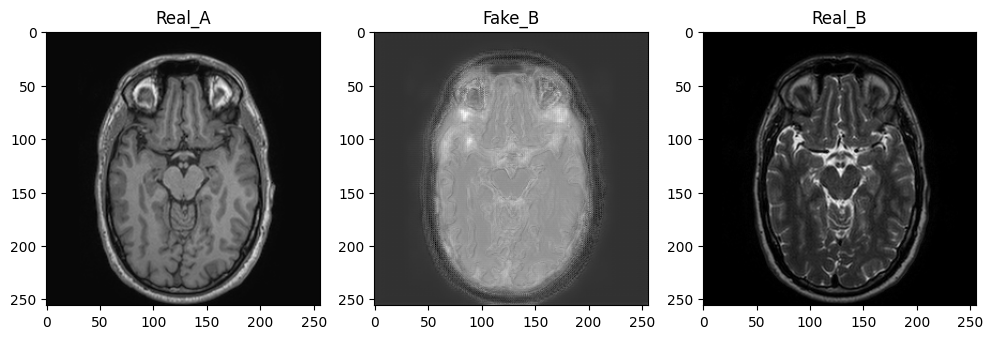

Validation Loss:  0.04566143290190906 Average PSNR:  20.32308219238952 Average SSIM:  0.586443563411524


Epoch 19: 100%|█████████| 76/76 [00:10<00:00,  7.07it/s, recons_loss=0.0784, gen_loss=1.02, disc_loss=0.00197]


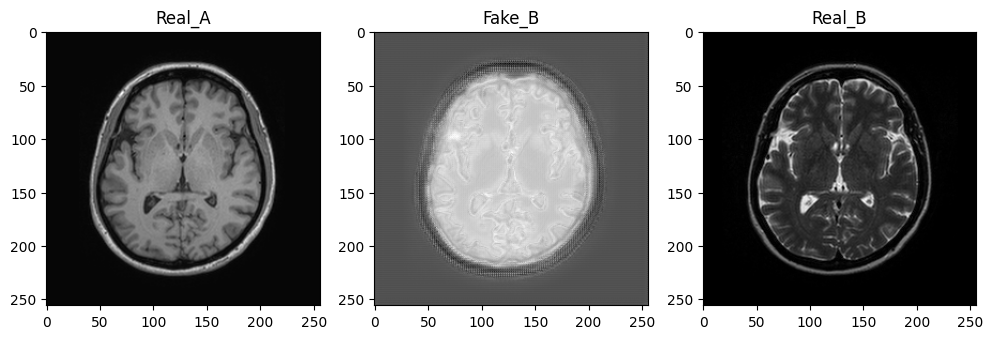

Validation Loss:  0.049291352534687125 Average PSNR:  19.884507143628465 Average SSIM:  0.46776575367529316


Epoch 29: 100%|█████████| 76/76 [00:10<00:00,  7.11it/s, recons_loss=0.0768, gen_loss=1.02, disc_loss=0.00167]


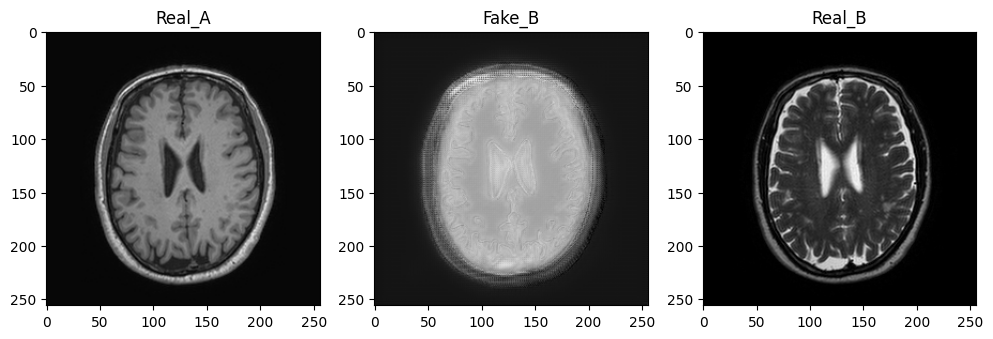

Validation Loss:  0.04541340919805097 Average PSNR:  20.168027475378015 Average SSIM:  0.5979288990680988


Epoch 39: 100%|█████████| 76/76 [00:10<00:00,  7.29it/s, recons_loss=0.0769, gen_loss=1.01, disc_loss=0.00224]


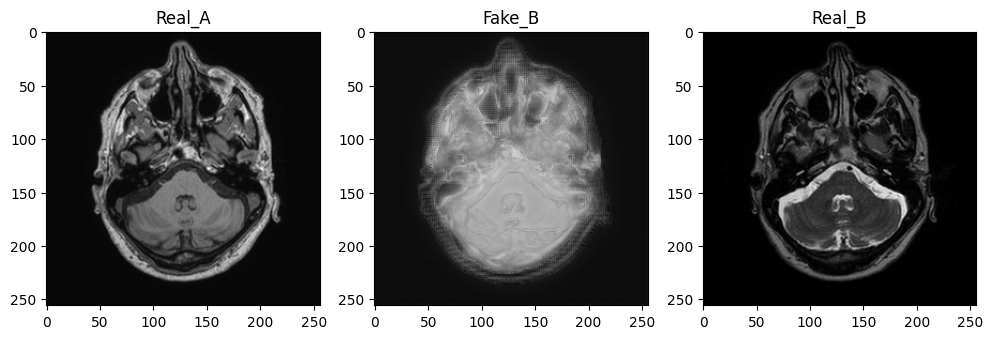

Validation Loss:  0.04681080389808823 Average PSNR:  20.116764865078768 Average SSIM:  0.5928478636584439


Epoch 49: 100%|█████████| 76/76 [00:10<00:00,  7.17it/s, recons_loss=0.0779, gen_loss=1.02, disc_loss=0.00628]


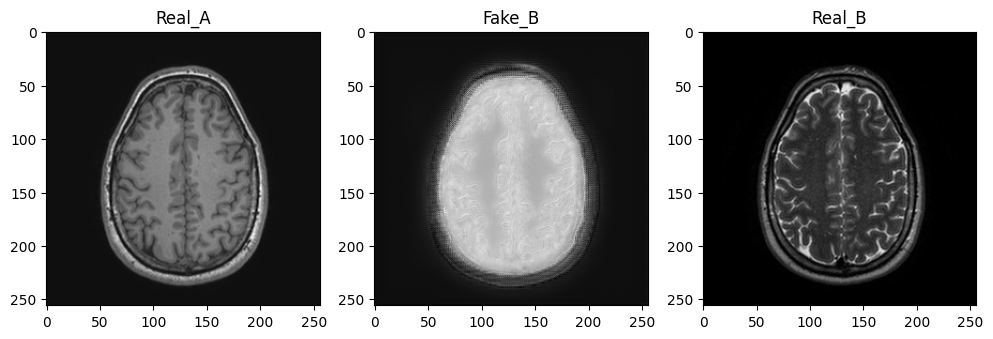

Validation Loss:  0.04571455528366042 Average PSNR:  19.85438634432279 Average SSIM:  0.6185428010893392


Epoch 59: 100%|█████████| 76/76 [00:11<00:00,  6.86it/s, recons_loss=0.0763, gen_loss=1.01, disc_loss=0.00234]


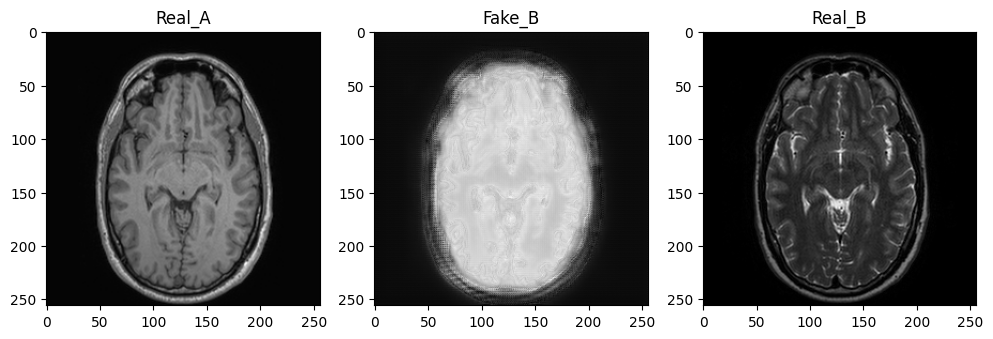

Validation Loss:  0.046977359760593584 Average PSNR:  19.922806666447567 Average SSIM:  0.5883130154766879


Epoch 69: 100%|██████████| 76/76 [00:10<00:00,  7.12it/s, recons_loss=0.0751, gen_loss=1.01, disc_loss=0.0011]


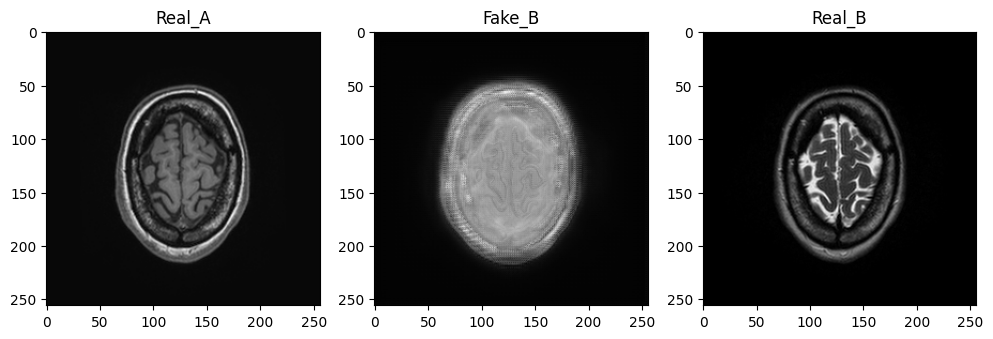

Validation Loss:  0.04473046378365585 Average PSNR:  20.294422778454457 Average SSIM:  0.6179133315662761


Epoch 79: 100%|████████| 76/76 [00:10<00:00,  7.10it/s, recons_loss=0.0754, gen_loss=1.01, disc_loss=0.000569]


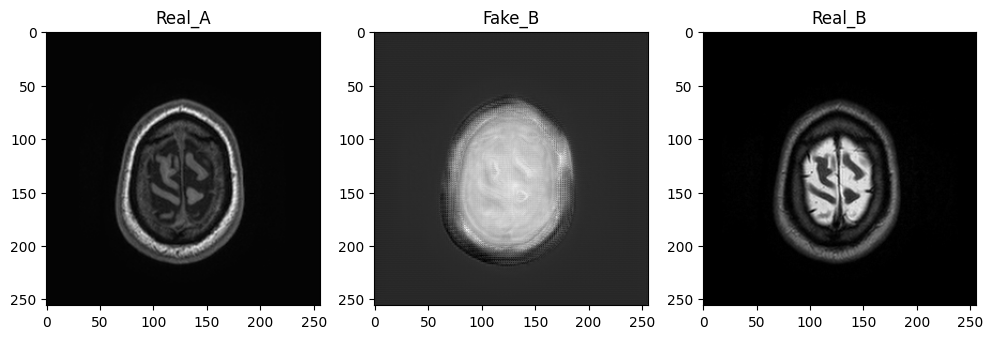

Validation Loss:  0.04477222288375372 Average PSNR:  20.057280165284546 Average SSIM:  0.6167178513584556


Epoch 89: 100%|████████| 76/76 [00:10<00:00,  7.18it/s, recons_loss=0.0738, gen_loss=1.01, disc_loss=0.000764]


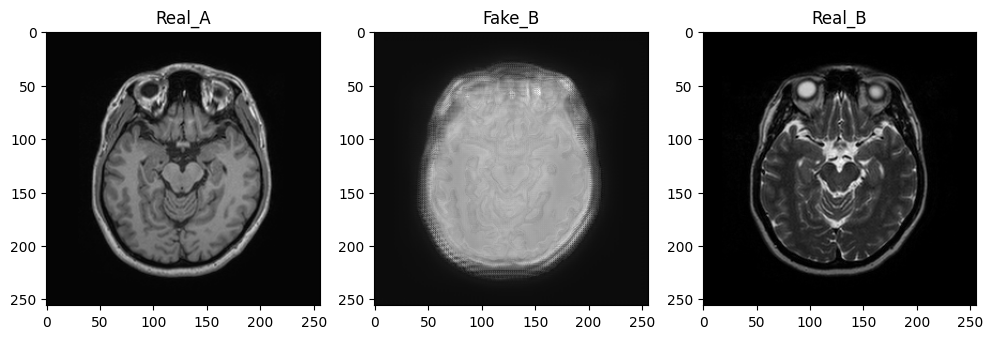

Validation Loss:  0.045016870086828434 Average PSNR:  20.114045627300555 Average SSIM:  0.6264258664387923


Epoch 99: 100%|████████| 76/76 [00:10<00:00,  7.32it/s, recons_loss=0.0763, gen_loss=1.01, disc_loss=0.000494]


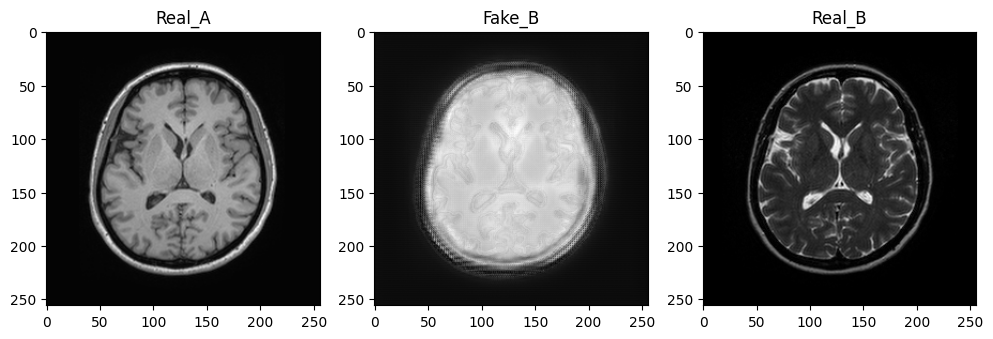

Validation Loss:  0.04609095658492911 Average PSNR:  19.819419756040467 Average SSIM:  0.6031670582163465


Epoch 109: 100%|█████████| 76/76 [00:10<00:00,  7.08it/s, recons_loss=0.075, gen_loss=1.02, disc_loss=0.00256]


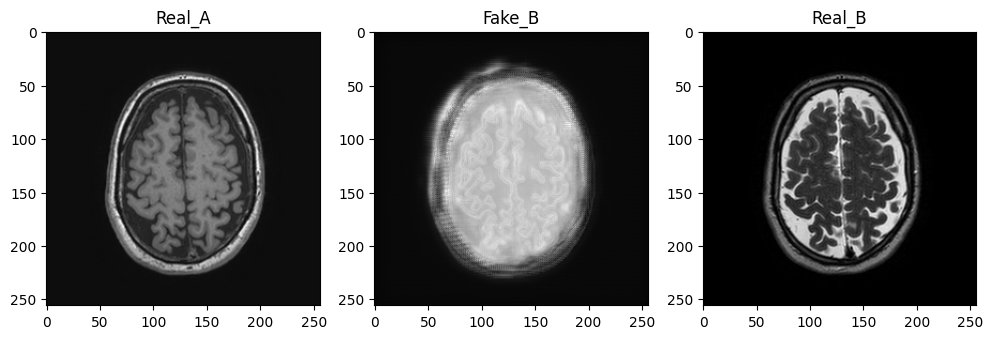

Validation Loss:  0.04581273572703639 Average PSNR:  19.98915830758902 Average SSIM:  0.614564082648728


Epoch 119: 100%|███████| 76/76 [00:10<00:00,  7.20it/s, recons_loss=0.0749, gen_loss=1.01, disc_loss=0.000903]


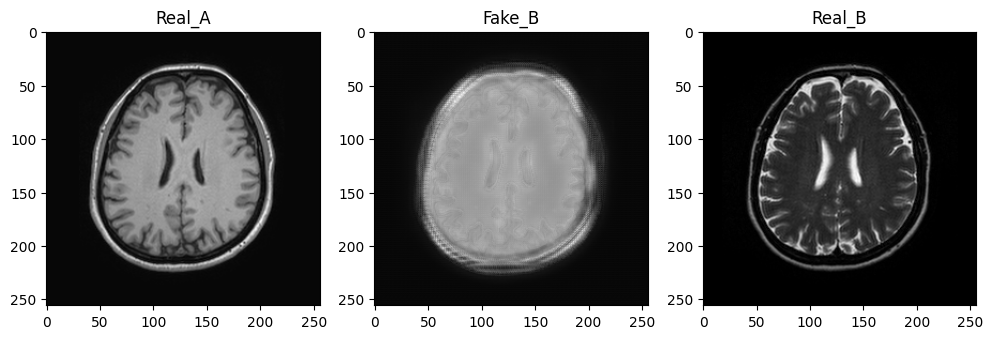

Validation Loss:  0.04590501285025052 Average PSNR:  20.12462631057907 Average SSIM:  0.6258993497261635


Epoch 129: 100%|███████| 76/76 [00:10<00:00,  7.07it/s, recons_loss=0.0753, gen_loss=1.01, disc_loss=0.000316]


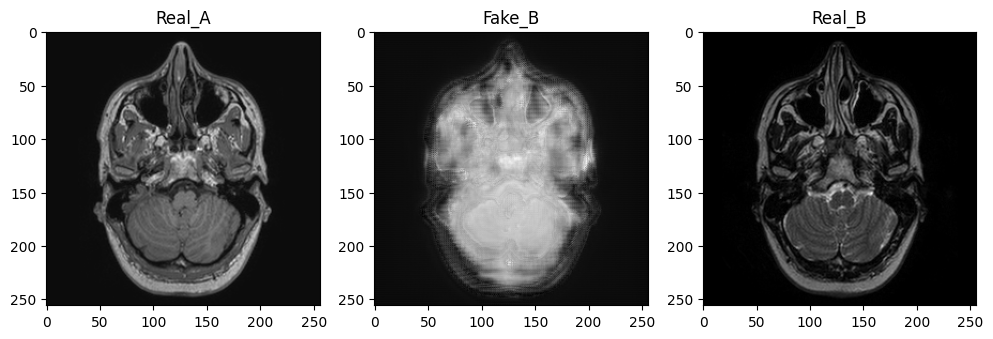

Validation Loss:  0.045092709509880986 Average PSNR:  20.012473603133316 Average SSIM:  0.61913729932282


Epoch 139: 100%|███████| 76/76 [00:10<00:00,  6.96it/s, recons_loss=0.0741, gen_loss=1.01, disc_loss=0.000261]


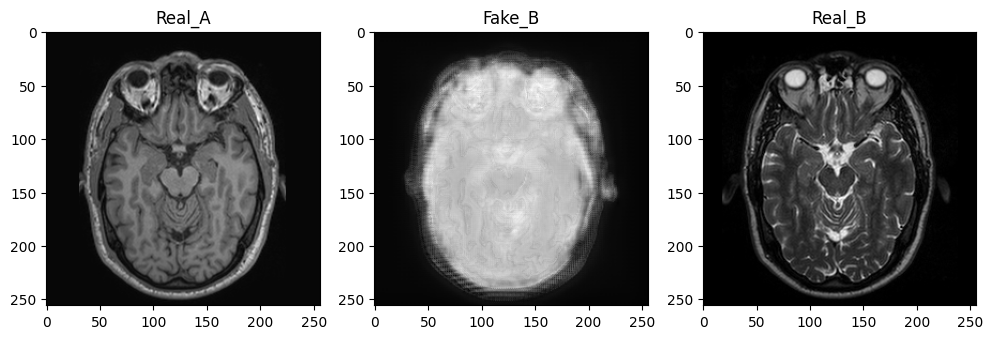

Validation Loss:  0.04622927905766518 Average PSNR:  19.88012073642605 Average SSIM:  0.6189396158679501


Epoch 149: 100%|█████████| 76/76 [00:10<00:00,  7.35it/s, recons_loss=0.0741, gen_loss=1.03, disc_loss=0.0103]


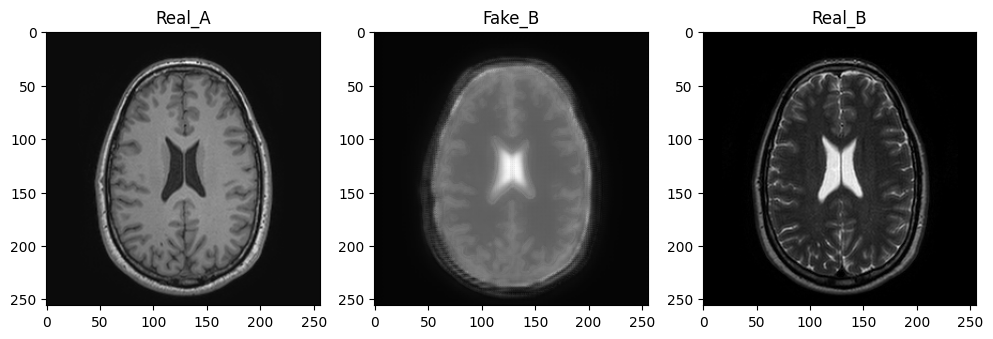

Validation Loss:  0.04476471682089371 Average PSNR:  20.386620452377823 Average SSIM:  0.6239803354818743


Epoch 159: 100%|██████████| 76/76 [00:11<00:00,  6.83it/s, recons_loss=0.0734, gen_loss=1, disc_loss=0.000311]


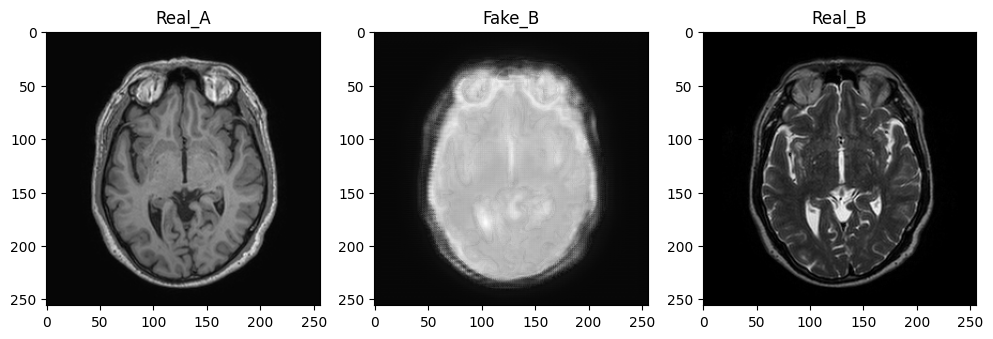

Validation Loss:  0.045362842856691434 Average PSNR:  20.219026796110384 Average SSIM:  0.6330559703019949


Epoch 169: 100%|██████████| 76/76 [00:10<00:00,  6.95it/s, recons_loss=0.0739, gen_loss=1, disc_loss=0.000221]


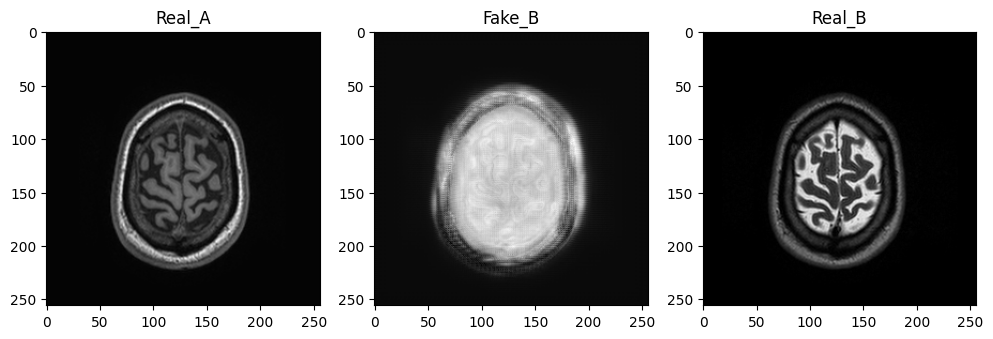

Validation Loss:  0.046216261669338406 Average PSNR:  19.876549253358945 Average SSIM:  0.6146653109199398


Epoch 179: 100%|██████████| 76/76 [00:10<00:00,  7.18it/s, recons_loss=0.0736, gen_loss=1, disc_loss=0.000201]


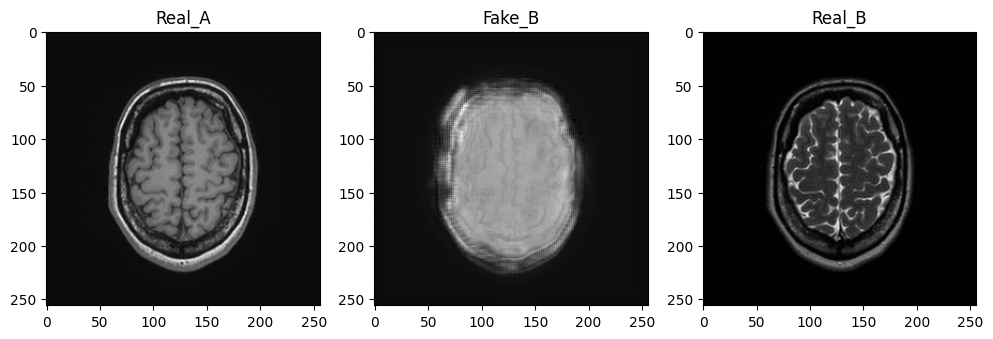

Validation Loss:  0.044316286618237964 Average PSNR:  20.21798921103006 Average SSIM:  0.6329521921964792


Epoch 184:  36%|███▌      | 27/76 [00:04<00:06,  7.55it/s, recons_loss=0.0733, gen_loss=1, disc_loss=0.000334]

In [12]:
# Example from : https://github.com/Project-MONAI/GenerativeModels/blob/main/tutorials/generative/2d_autoencoderkl/2d_autoencoderkl_tutorial.ipynb

from torch.nn.functional import mse_loss
from pytorch_msssim import ssim

n_epochs = 200
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, (t1,t2) in progress_bar:
        t1 = t1.to(device)
        t2 = t2.to(device)
        optimizer_g.zero_grad(set_to_none=True)

        reconstruction = model(t1)

        recons_loss = l1_loss(reconstruction.float(), t2.float()) # L1 loss

        logits_fake = discriminator(reconstruction.contiguous().float())[-1]
        p_loss = perceptual_loss(reconstruction.float(), t2.float()) # Perceptual loss
        generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False) # Adversarial loss
        loss_g = recons_loss + perceptual_weight * p_loss + adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()

        # Discriminator part (Updating discriminator)
        optimizer_d.zero_grad(set_to_none=True)

        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = discriminator(t2.contiguous().detach())[-1]
        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

        loss_d = adv_weight * discriminator_loss

        loss_d.backward()
        optimizer_d.step() # Updating discriminator

        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        total_psnr = 0
        total_ssim = 0
        with torch.no_grad():
            for val_step, (t1,t2) in enumerate(val_loader, start=1):
                t1 = t1.to(device)
                t2 = t2.to(device)
                reconstruction = model(t1)



                # get the first sammple from the first validation batch for visualisation
                # purposes
                recons_loss = l1_loss(reconstruction.float(), t2.float())

                val_loss += recons_loss.item()

                 # Calculate PSNR
                mse_val = mse_loss(reconstruction.float(), t2.float())
                psnr = 10 * torch.log10(1 / mse_val)
                total_psnr += psnr.item()

                # Calculate SSIM
                ssim_val = ssim(reconstruction.float(), t2.float(), data_range=1.0, size_average=True) # data_range: -1~1
                total_ssim += ssim_val.item()

                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])
                    out = get_current_visuals(t1.float(),reconstruction.float(),t2.float())
                    plot_images([out['real_A'], out['fake_B'], out['real_B']], ['Real_A', 'Fake_B', 'Real_B'])

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)
        
        avg_psnr = total_psnr / val_step
        avg_ssim = total_ssim / val_step

         # Print the PSNR and SSIM values along with the loss
        print("Validation Loss: ", val_loss, "Average PSNR: ", avg_psnr, "Average SSIM: ", avg_ssim)


total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

In [ ]:
# TODO: Step2_PGAN.ipynb -> Step2_PGAN_daniel.ipynb 로 정리
# TODO: Add scaling the images (too grayish)
# TODO: Make CycleGAN model, L1-loss model
# TODO: train_pgan.py, train_cgan.py, train_l1loss.py 로 정리
# TODO: Add saving PSNR & SSIM
# TODO: evaluate.ipynb

In [ ]:
import pytorch_lightning as pl

class MyModel(pl.LightningModule):

    def __init__(self, model, discriminator, l1_loss, perceptual_loss, adv_loss, perceptual_weight, adv_weight):
        super().__init__()
        self.model = model
        self.discriminator = discriminator
        self.l1_loss = l1_loss
        self.perceptual_loss = perceptual_loss
        self.adv_loss = adv_loss
        self.perceptual_weight = perceptual_weight
        self.adv_weight = adv_weight

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx, optimizer_idx):
        t1, t2 = batch
        t1 = t1.to(self.device)
        t2 = t2.to(self.device)

        # Generator update
        if optimizer_idx == 0:
            self.optimizers()[0].zero_grad()
            reconstruction = self(t1)
            recons_loss = self.l1_loss(reconstruction.float(), t2.float())
            logits_fake = self.discriminator(reconstruction.contiguous().float())[-1]
            p_loss = self.perceptual_loss(reconstruction.float(), t2.float())
            generator_loss = self.adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g = recons_loss + self.perceptual_weight * p_loss + self.adv_weight * generator_loss
            self.log('train_gen_loss', loss_g)
            return loss_g

        # Discriminator update
        if optimizer_idx == 1:
            self.optimizers()[1].zero_grad()
            logits_fake = self.discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = self.adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = self.discriminator(t2.contiguous().detach())[-1]
            loss_d_real = self.adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5
            loss_d = self.adv_weight * discriminator_loss
            self.log('train_disc_loss', loss_d)
            return loss_d

    def validation_step(self, batch, batch_idx):
        t1, t2 = batch
        t1 = t1.to(self.device)
        t2 = t2.to(self.device)
        reconstruction = self(t1)
        recons_loss = self.l1_loss(reconstruction.float(), t2.float())
        self.log('val_loss', recons_loss)

    def configure_optimizers(self):
        optimizer_g = torch.optim.Adam(self.model.parameters(), lr=0.0002)
        optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002)
        return optimizer_g, optimizer_d



In [ ]:
print(model)